# Replication of results by Pentland et al. 2020

## Setup

In [16]:
import numpy as np
import math
import random
import process_simulation
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
import scipy
from tqdm.notebook import tqdm
import time
import pandas as pd
from joblib import Parallel, delayed

# reload the process_simulation
import importlib
importlib.reload(process_simulation)


<module 'process_simulation' from 'c:\\Users\\Lennart Ebert\\OneDrive - McKinsey & Company\\Documents\\04_phd\\02_workspace\\upc_csn_08_final_project\\process_simulation.py'>

## Perform and plot single simulation

In [17]:
# ### simulation parameters in accordance with Pentland p.27 (lowest bounds for all parameters except r)
t = 5000 # number of iterations (5000 default)
l = 100 # lexicon: number of different process steps
m = 5 # number of subunits of the process, needs to be a factor of l
r = 50 # number of historic sequences remembered
v = 0.01 # chance of variation
n = 5

# t = 10 # number of iterations (5000 default)
# l = 3 # lexicon: number of different process steps
# m = 1 # number of subunits of the process, needs to be a factor of l
# r = 3 # size of the history matrix
# v = 0.4 # chance of variation
# n = 5

In [18]:
my_simulation = process_simulation.ProcessSimulationModel(t, l, m, r, n, v)

In [20]:
# run the simulation and store runtime dynamics
import cProfile
import pstats
from io import StringIO

# Create a profiler object
profiler = cProfile.Profile()

# Start profiling
profiler.enable()

# Run the simulation
adjacency_matrices = my_simulation.run_simulation(normalize_adjacency_matrices=True)

# Stop profiling
profiler.disable()

# Create a stream to hold the profile data
stream = StringIO()

# Create a Stats object and sort the profile data
stats = pstats.Stats(profiler, stream=stream).sort_stats(pstats.SortKey.CUMULATIVE)

# Print the profile to stream
stats.print_stats()

# Display the profile data in the Jupyter notebook
profile_data = stream.getvalue()
print(profile_data)

# Optionally, you can save the profile data to a file for later analysis
with open("profile_output.txt", "w") as f:
    f.write(stream.getvalue())

         9794517 function calls (9784517 primitive calls) in 7.101 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    7.101    3.551 c:\Users\Lennart Ebert\.conda\envs\process_simulation\lib\site-packages\IPython\core\interactiveshell.py:3472(run_code)
        2    0.000    0.000    7.101    3.551 {built-in method builtins.exec}
        1    0.152    0.152    7.101    7.101 C:\Users\Lennart Ebert\AppData\Local\Temp\ipykernel_26088\2671428621.py:13(<module>)
        1    0.497    0.497    6.949    6.949 c:\Users\Lennart Ebert\OneDrive - McKinsey & Company\Documents\04_phd\02_workspace\upc_csn_08_final_project\process_simulation.py:130(run_simulation)
     5000    1.081    0.000    5.929    0.001 c:\Users\Lennart Ebert\OneDrive - McKinsey & Company\Documents\04_phd\02_workspace\upc_csn_08_final_project\process_simulation.py:90(next_sequence)
1048293/1038293    0.785    0.000    4.157    0.000 {bu

In [21]:
# sampled_adjacency_matrices = process_simulation.sample_adjacency_matrices(adjacency_matrices, 101)
results_df = process_simulation.get_metrics_for_sim_results(adjacency_matrices, metrics=['number of connected nodes', 'number of edges', 'density', 'avg degree', 'est. count simple paths'], monte_carlo_iterations=n*l)
results_df

,number of connected nodes,number of edges,avg degree,density,est. count simple paths
time,,,,,
0,100,100,1.000000,0.010101,1.202264
1,100,100,1.000000,0.010101,1.202264
2,100,100,1.000000,0.010101,1.202264
3,100,101,1.010000,0.010202,1.445440
4,100,101,1.010000,0.010202,1.445440
...,...,...,...,...,...
4995,85,149,1.752941,0.020868,10000.000000
4996,85,149,1.752941,0.020868,10000.000000
4997,85,149,1.752941,0.020868,10000.000000


## Comparisson of Complexity metrics

In [22]:
results_df_norm = pd.DataFrame()

# normalize all complexity metrics to plot them in one graph and observe their differences
def absolute_maximum_scale(series):
    return series / series.abs().max()
for col in results_df.columns:
    results_df_norm[col] = absolute_maximum_scale(results_df[col])

# only show a few timestamps
# print(results_df_norm.iloc[::5].to_latex())
display(results_df_norm.head)

<bound method NDFrame.head of       number of connected nodes  number of edges  avg degree   density  \
time                                                                     
0                          1.00         0.386100    0.386100  0.292793   
1                          1.00         0.386100    0.386100  0.292793   
2                          1.00         0.386100    0.386100  0.292793   
3                          1.00         0.389961    0.389961  0.295721   
4                          1.00         0.389961    0.389961  0.295721   
...                         ...              ...         ...       ...   
4995                       0.85         0.575290    0.676811  0.604900   
4996                       0.85         0.575290    0.676811  0.604900   
4997                       0.85         0.575290    0.676811  0.604900   
4998                       0.85         0.575290    0.676811  0.604900   
4999                       0.85         0.579151    0.681354  0.608960   

      e

In [23]:
results_df_norm.corr()

,number of connected nodes,number of edges,avg degree,density,est. count simple paths
number of connected nodes,1.000000,0.806513,0.426722,-0.460098,0.321630
number of edges,0.806513,1.000000,0.875010,0.136399,0.471231
avg degree,0.426722,0.875010,1.000000,0.596882,0.429833
density,-0.460098,0.136399,0.596882,1.000000,0.114679
est. count simple paths,0.321630,0.471231,0.429833,0.114679,1.000000


<Figure size 640x480 with 0 Axes>

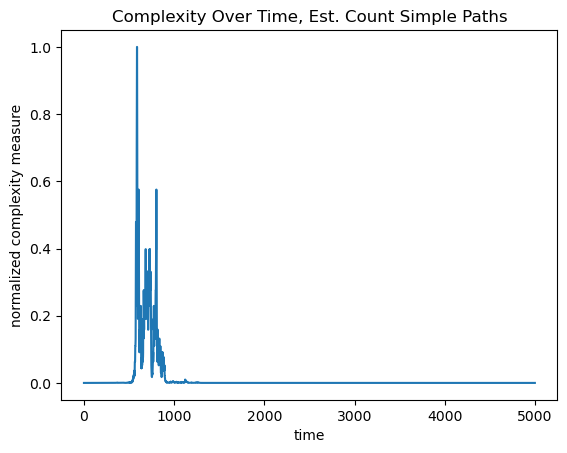

In [24]:
f = plt.figure()
ax = results_df_norm[['est. count simple paths']].plot(title="Complexity Over Time, Est. Count Simple Paths")
ax.set_ylabel("normalized complexity measure")
ax.get_legend().remove()
plt.savefig('experiment_results/plot_complexity_simple paths.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

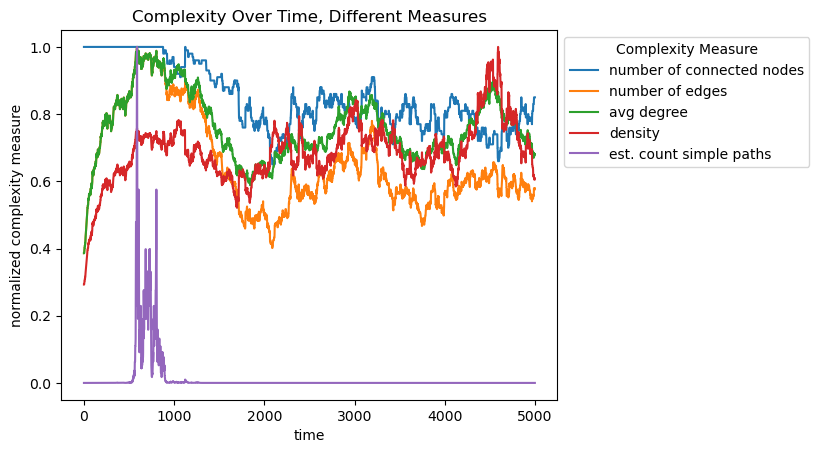

In [25]:
f = plt.figure()
ax = results_df_norm.plot(title="Complexity Over Time, Different Measures")
ax.set_ylabel("normalized complexity measure")
legend = plt.legend(title='Complexity Measure', bbox_to_anchor=(1.0, 1.0))
legend_frame = legend.get_frame()
legend_frame.set_facecolor('white')

plt.savefig('experiment_results/plot_complexity_measures.png', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

<Axes: xlabel='time'>

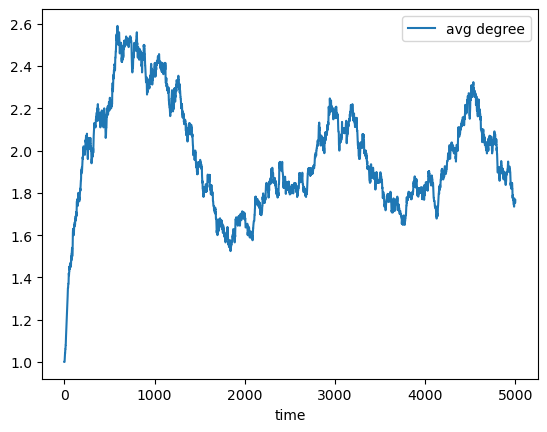

In [26]:
results_df.plot(y='avg degree')

<Axes: xlabel='time'>

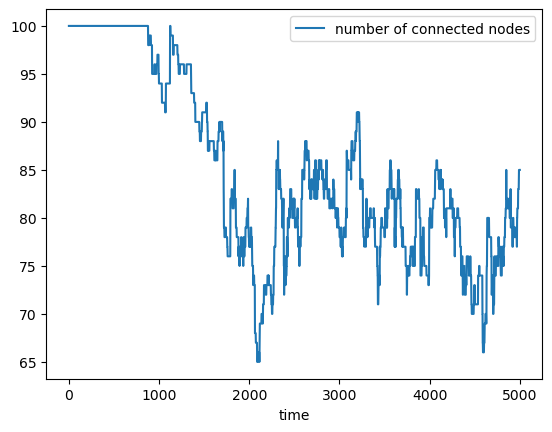

In [27]:
results_df.plot(y='number of connected nodes')

## Plot some graphs at different times    

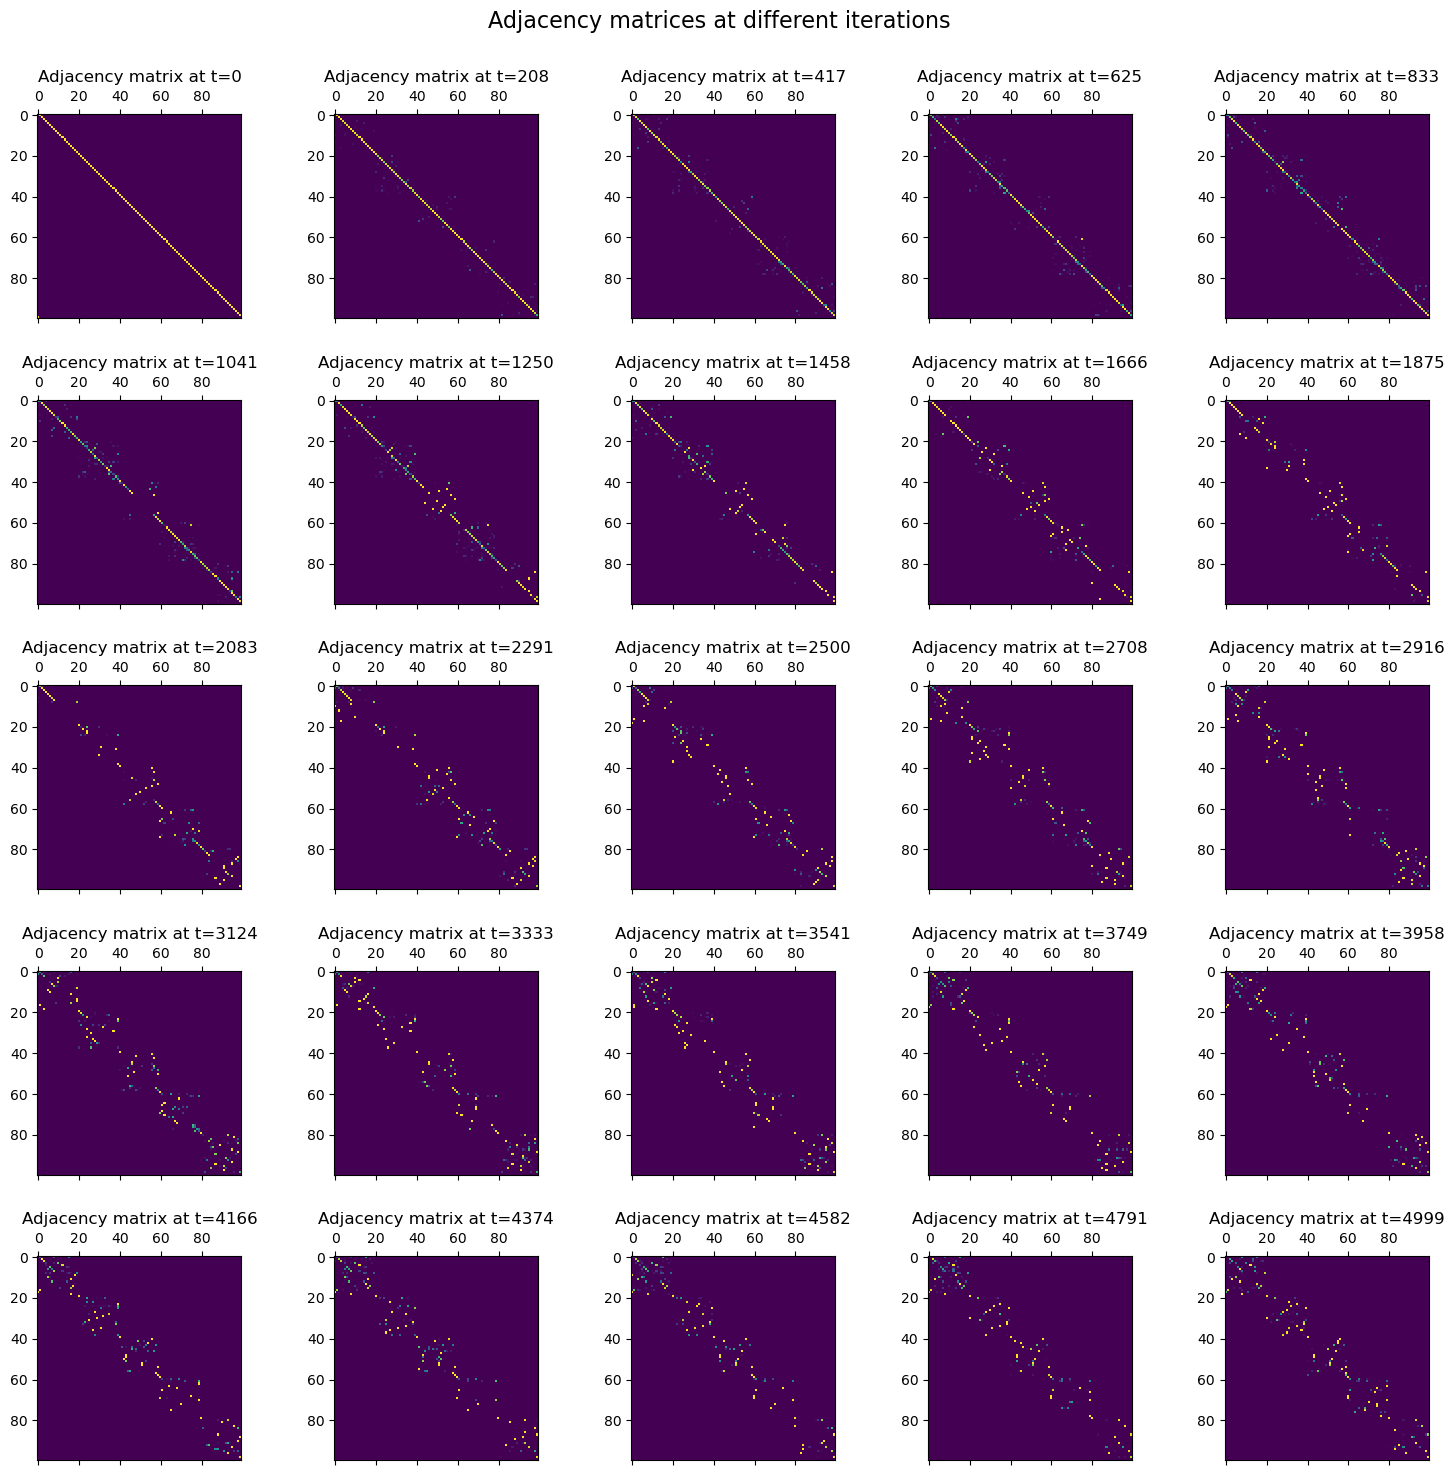

In [28]:
number_of_plots = 5*5

sampled_adjacency_matrices = process_simulation.sample_adjacency_matrices(adjacency_matrices, number_of_plots)

# Number of columns is fixed at 5
num_cols = 5
num_matrices = len(sampled_adjacency_matrices)
num_rows = (num_matrices + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Plot each adjacency matrix in its respective subplot
for idx, (i, adjacency_matrix) in enumerate(sampled_adjacency_matrices.items()):
    axes[idx].matshow(adjacency_matrix)
    axes[idx].set_title(f"Adjacency matrix at t={i}")

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95]) # add some space at the top
plt.subplots_adjust(hspace=0.4) 

# Show the plot
fig.suptitle('Adjacency matrices at different iterations', fontsize=16)
plt.show()

In [29]:
# get metrics for simulation that can be compared to Pentland
aggregate_sim_result = process_simulation.get_aggregate_sim_result(adjacency_matrices, l)
aggregate_sim_result

{'max_complexity': 208929613085404.1,
 'mean_complexity': 2045966563647.5776,
 'has_phase_change': True,
 'time_to_complexity': 563}

## Perform many iterations to confirm adherence to Pentland results

In [30]:
### simulation parameters in accordance with Pentland p.27
t = 5000 # number of iterations # default: 5000
l = 100 # lexicon: number of different process steps # default: 100
m = 5 # number of subunits of the process, needs to be a factor of l # default: 5
r = 50 # size of the history matrix # default: 50
v = 0.01 # chance of variation # default: 0.01
n = 5 # default: 5

simulation_runs = 500

my_simulation = process_simulation.ProcessSimulationModel(t, l, m, r, n, v)

def run_simulation_and_get_results(my_simulation):
    adjacency_matrices = my_simulation.run_simulation()
    simulation_result = process_simulation.get_aggregate_sim_result(adjacency_matrices, l)
    return simulation_result

# List to store simulation results
simulation_results = Parallel(n_jobs=16)(delayed(run_simulation_and_get_results)(my_simulation) for _ in range(simulation_runs))

# Convert the results to a DataFrame
results_df = pd.DataFrame(simulation_results)
display(results_df.head())
display(results_df.mean())

,max_complexity,mean_complexity,has_phase_change,time_to_complexity
0,1.905461e+11,2.751704e+09,True,249
1,3.311311e+13,6.104806e+11,False,943
2,6.918310e+13,6.907181e+11,True,2132
3,2.511886e+12,2.779270e+10,True,542
4,5.248075e+16,2.520305e+14,False,4327


max_complexity        5.784888e+26
mean_complexity       1.885942e+24
has_phase_change      7.260000e-01
time_to_complexity    1.256188e+03
dtype: float64